# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [37]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

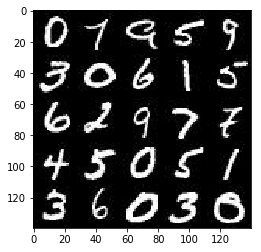

In [38]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

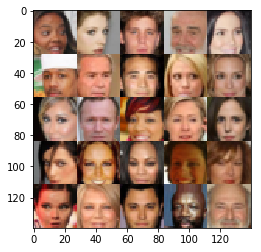

In [39]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [41]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [42]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [43]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
        
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # Output layer        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [44]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [45]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)  
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
       
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model  
    input_real, input_z, lr_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_z: batch_z * 2, input_real: batch_images * 2})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr_rate: learning_rate, input_real: batch_images})
                              
                if steps % 10 == 0:
                    
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Steps {}/{}...".format(steps, epoch_i + 1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)  
        
            print ("After epoch")
            show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
            
    print ("Done")
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Steps 10/1... Discriminator Loss: 1.7347... Generator Loss: 0.8070
Steps 20/1... Discriminator Loss: 0.5458... Generator Loss: 18.0350
Steps 30/1... Discriminator Loss: 0.8608... Generator Loss: 14.4414
Steps 40/1... Discriminator Loss: 1.0498... Generator Loss: 2.8556
Steps 50/1... Discriminator Loss: 0.4486... Generator Loss: 2.7117
Steps 60/1... Discriminator Loss: 0.4019... Generator Loss: 4.5985
Steps 70/1... Discriminator Loss: 0.3377... Generator Loss: 6.5882
Steps 80/1... Discriminator Loss: 0.3415... Generator Loss: 6.6856
Steps 90/1... Discriminator Loss: 0.3349... Generator Loss: 6.7127
Steps 100/1... Discriminator Loss: 0.4930... Generator Loss: 5.6363


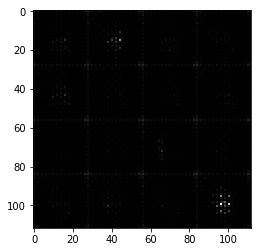

Steps 110/1... Discriminator Loss: 0.7548... Generator Loss: 2.5545
Steps 120/1... Discriminator Loss: 0.4913... Generator Loss: 2.4737
Steps 130/1... Discriminator Loss: 1.3881... Generator Loss: 0.7817
Steps 140/1... Discriminator Loss: 0.9485... Generator Loss: 2.3402
Steps 150/1... Discriminator Loss: 1.0187... Generator Loss: 1.4790
Steps 160/1... Discriminator Loss: 0.9694... Generator Loss: 1.3462
Steps 170/1... Discriminator Loss: 1.1512... Generator Loss: 1.5288
Steps 180/1... Discriminator Loss: 0.9427... Generator Loss: 1.0958
Steps 190/1... Discriminator Loss: 1.6317... Generator Loss: 0.3851
Steps 200/1... Discriminator Loss: 1.0327... Generator Loss: 1.8986


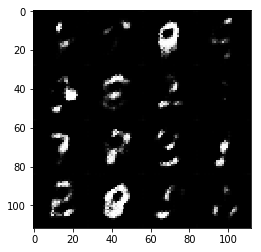

Steps 210/1... Discriminator Loss: 1.4927... Generator Loss: 0.4514
Steps 220/1... Discriminator Loss: 1.0381... Generator Loss: 0.8707
Steps 230/1... Discriminator Loss: 1.0781... Generator Loss: 0.9445
Steps 240/1... Discriminator Loss: 1.0168... Generator Loss: 0.8301
Steps 250/1... Discriminator Loss: 0.8569... Generator Loss: 2.0248
Steps 260/1... Discriminator Loss: 0.9942... Generator Loss: 1.3183
Steps 270/1... Discriminator Loss: 1.0844... Generator Loss: 0.8982
Steps 280/1... Discriminator Loss: 1.1901... Generator Loss: 2.0377
Steps 290/1... Discriminator Loss: 1.6279... Generator Loss: 0.3970
Steps 300/1... Discriminator Loss: 0.6901... Generator Loss: 1.7765


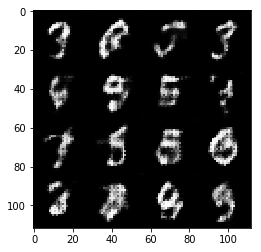

Steps 310/1... Discriminator Loss: 0.7767... Generator Loss: 1.9648
Steps 320/1... Discriminator Loss: 0.9830... Generator Loss: 1.0624
Steps 330/1... Discriminator Loss: 0.9939... Generator Loss: 1.0997
Steps 340/1... Discriminator Loss: 1.1664... Generator Loss: 1.1505
Steps 350/1... Discriminator Loss: 1.0305... Generator Loss: 1.1924
Steps 360/1... Discriminator Loss: 1.2441... Generator Loss: 1.5083
Steps 370/1... Discriminator Loss: 1.3961... Generator Loss: 0.5830
Steps 380/1... Discriminator Loss: 1.0804... Generator Loss: 0.9467
Steps 390/1... Discriminator Loss: 1.6478... Generator Loss: 0.4181
Steps 400/1... Discriminator Loss: 1.1209... Generator Loss: 0.9163


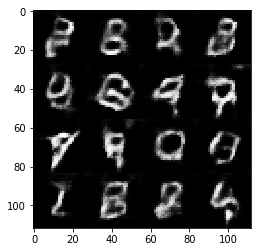

Steps 410/1... Discriminator Loss: 1.1015... Generator Loss: 0.9027
Steps 420/1... Discriminator Loss: 1.3776... Generator Loss: 0.6698
Steps 430/1... Discriminator Loss: 1.1927... Generator Loss: 0.8322
Steps 440/1... Discriminator Loss: 1.2709... Generator Loss: 0.7471
Steps 450/1... Discriminator Loss: 1.0449... Generator Loss: 1.1350
Steps 460/1... Discriminator Loss: 1.2301... Generator Loss: 0.8712
After epoch


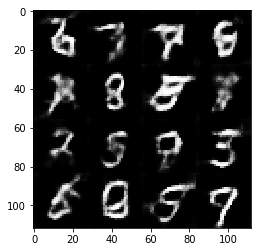

Steps 10/2... Discriminator Loss: 1.2440... Generator Loss: 0.8727
Steps 20/2... Discriminator Loss: 1.1694... Generator Loss: 1.1206
Steps 30/2... Discriminator Loss: 1.5855... Generator Loss: 1.8230
Steps 40/2... Discriminator Loss: 1.1665... Generator Loss: 1.0927
Steps 50/2... Discriminator Loss: 1.3003... Generator Loss: 0.7502
Steps 60/2... Discriminator Loss: 1.2233... Generator Loss: 0.8185
Steps 70/2... Discriminator Loss: 1.3145... Generator Loss: 0.6975
Steps 80/2... Discriminator Loss: 1.1172... Generator Loss: 0.9748
Steps 90/2... Discriminator Loss: 1.4852... Generator Loss: 0.5470
Steps 100/2... Discriminator Loss: 1.4759... Generator Loss: 1.4448


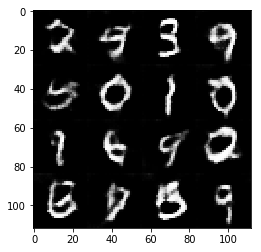

Steps 110/2... Discriminator Loss: 1.8540... Generator Loss: 1.5821
Steps 120/2... Discriminator Loss: 1.2925... Generator Loss: 0.7508
Steps 130/2... Discriminator Loss: 1.5452... Generator Loss: 1.6049
Steps 140/2... Discriminator Loss: 1.7985... Generator Loss: 1.8683
Steps 150/2... Discriminator Loss: 1.4944... Generator Loss: 1.2619
Steps 160/2... Discriminator Loss: 1.5457... Generator Loss: 1.4093
Steps 170/2... Discriminator Loss: 1.5916... Generator Loss: 0.5159
Steps 180/2... Discriminator Loss: 1.3034... Generator Loss: 1.0035
Steps 190/2... Discriminator Loss: 1.6077... Generator Loss: 0.4669
Steps 200/2... Discriminator Loss: 1.4732... Generator Loss: 0.8240


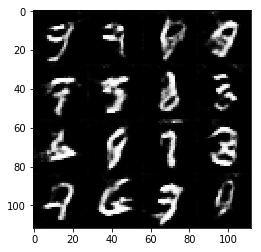

Steps 210/2... Discriminator Loss: 1.7444... Generator Loss: 0.3541
Steps 220/2... Discriminator Loss: 1.4369... Generator Loss: 0.9186
Steps 230/2... Discriminator Loss: 1.7778... Generator Loss: 1.4028
Steps 240/2... Discriminator Loss: 1.4287... Generator Loss: 1.1032
Steps 250/2... Discriminator Loss: 1.6143... Generator Loss: 0.5644
Steps 260/2... Discriminator Loss: 1.5963... Generator Loss: 1.0980
Steps 270/2... Discriminator Loss: 1.9186... Generator Loss: 1.2414
Steps 280/2... Discriminator Loss: 1.6945... Generator Loss: 0.4341
Steps 290/2... Discriminator Loss: 1.5097... Generator Loss: 0.9100
Steps 300/2... Discriminator Loss: 1.5034... Generator Loss: 0.7735


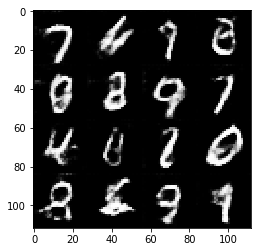

Steps 310/2... Discriminator Loss: 1.8137... Generator Loss: 0.7237
Steps 320/2... Discriminator Loss: 2.1139... Generator Loss: 1.1027
Steps 330/2... Discriminator Loss: 1.6798... Generator Loss: 2.2877
Steps 340/2... Discriminator Loss: 1.4166... Generator Loss: 1.0849
Steps 350/2... Discriminator Loss: 1.7009... Generator Loss: 0.6156
Steps 360/2... Discriminator Loss: 1.7443... Generator Loss: 1.6989
Steps 370/2... Discriminator Loss: 2.0073... Generator Loss: 1.5340
Steps 380/2... Discriminator Loss: 1.4078... Generator Loss: 1.7582
Steps 390/2... Discriminator Loss: 2.0385... Generator Loss: 0.6273
Steps 400/2... Discriminator Loss: 1.9646... Generator Loss: 0.6102


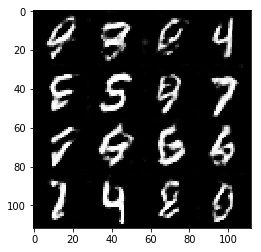

Steps 410/2... Discriminator Loss: 1.8640... Generator Loss: 1.2803
Steps 420/2... Discriminator Loss: 1.3952... Generator Loss: 0.7510
Steps 430/2... Discriminator Loss: 1.4369... Generator Loss: 1.7671
Steps 440/2... Discriminator Loss: 1.6487... Generator Loss: 1.1627
Steps 450/2... Discriminator Loss: 2.6243... Generator Loss: 1.0874
Steps 460/2... Discriminator Loss: 2.2599... Generator Loss: 0.3993
After epoch


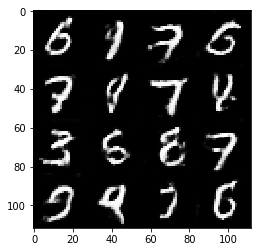

Done


In [49]:
batch_size = 128
z_dim = 100
learning_rate = 0.00085
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Steps 10/1... Discriminator Loss: 3.6495... Generator Loss: 0.1551
Steps 20/1... Discriminator Loss: 1.0957... Generator Loss: 1.9451
Steps 30/1... Discriminator Loss: 1.9940... Generator Loss: 0.3390
Steps 40/1... Discriminator Loss: 1.8143... Generator Loss: 5.2253
Steps 50/1... Discriminator Loss: 0.8426... Generator Loss: 1.2376
Steps 60/1... Discriminator Loss: 1.5808... Generator Loss: 8.2364
Steps 70/1... Discriminator Loss: 0.7951... Generator Loss: 1.2535
Steps 80/1... Discriminator Loss: 1.5563... Generator Loss: 0.4999
Steps 90/1... Discriminator Loss: 0.7359... Generator Loss: 1.4851
Steps 100/1... Discriminator Loss: 0.6771... Generator Loss: 1.9332


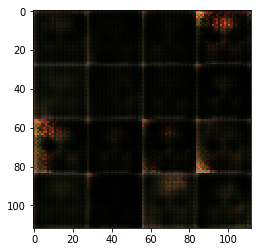

Steps 110/1... Discriminator Loss: 0.7971... Generator Loss: 1.5416
Steps 120/1... Discriminator Loss: 0.5853... Generator Loss: 1.9500
Steps 130/1... Discriminator Loss: 0.4003... Generator Loss: 3.9028
Steps 140/1... Discriminator Loss: 0.7873... Generator Loss: 1.2679
Steps 150/1... Discriminator Loss: 1.1775... Generator Loss: 0.8667
Steps 160/1... Discriminator Loss: 0.7411... Generator Loss: 1.3740
Steps 170/1... Discriminator Loss: 0.7098... Generator Loss: 1.3473
Steps 180/1... Discriminator Loss: 1.2861... Generator Loss: 0.5354
Steps 190/1... Discriminator Loss: 0.9956... Generator Loss: 0.7896
Steps 200/1... Discriminator Loss: 1.0864... Generator Loss: 0.8065


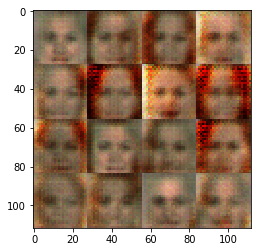

Steps 210/1... Discriminator Loss: 1.6101... Generator Loss: 0.3723
Steps 220/1... Discriminator Loss: 1.2683... Generator Loss: 0.6070
Steps 230/1... Discriminator Loss: 0.8873... Generator Loss: 1.0745
Steps 240/1... Discriminator Loss: 0.6999... Generator Loss: 1.4683
Steps 250/1... Discriminator Loss: 0.8600... Generator Loss: 1.0341
Steps 260/1... Discriminator Loss: 0.9368... Generator Loss: 0.8974
Steps 270/1... Discriminator Loss: 0.8497... Generator Loss: 0.9892
Steps 280/1... Discriminator Loss: 1.1003... Generator Loss: 0.7331
Steps 290/1... Discriminator Loss: 0.7388... Generator Loss: 1.2497
Steps 300/1... Discriminator Loss: 1.3137... Generator Loss: 0.5106


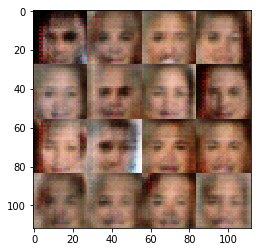

Steps 310/1... Discriminator Loss: 0.8317... Generator Loss: 1.9677
Steps 320/1... Discriminator Loss: 1.1428... Generator Loss: 0.6380
Steps 330/1... Discriminator Loss: 0.8620... Generator Loss: 0.9779
Steps 340/1... Discriminator Loss: 0.9168... Generator Loss: 0.8875
Steps 350/1... Discriminator Loss: 1.5244... Generator Loss: 0.4147
Steps 360/1... Discriminator Loss: 1.8086... Generator Loss: 0.2873
Steps 370/1... Discriminator Loss: 0.6450... Generator Loss: 1.6564
Steps 380/1... Discriminator Loss: 0.6761... Generator Loss: 1.8088
Steps 390/1... Discriminator Loss: 0.5880... Generator Loss: 1.6908
Steps 400/1... Discriminator Loss: 0.7368... Generator Loss: 1.5282


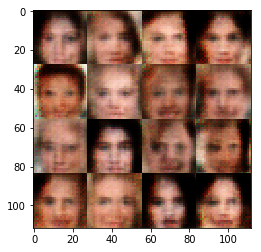

Steps 410/1... Discriminator Loss: 0.8201... Generator Loss: 1.0884
Steps 420/1... Discriminator Loss: 0.9601... Generator Loss: 0.8596
Steps 430/1... Discriminator Loss: 1.0036... Generator Loss: 0.7945
Steps 440/1... Discriminator Loss: 0.9425... Generator Loss: 0.8826
Steps 450/1... Discriminator Loss: 0.9980... Generator Loss: 0.7827
Steps 460/1... Discriminator Loss: 1.1945... Generator Loss: 0.5834
Steps 470/1... Discriminator Loss: 1.1159... Generator Loss: 0.6862
Steps 480/1... Discriminator Loss: 0.7649... Generator Loss: 1.2009
Steps 490/1... Discriminator Loss: 1.1800... Generator Loss: 0.6327
Steps 500/1... Discriminator Loss: 1.2626... Generator Loss: 0.5514


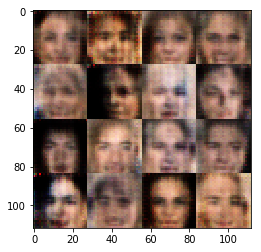

Steps 510/1... Discriminator Loss: 0.7800... Generator Loss: 1.3622
Steps 520/1... Discriminator Loss: 1.0456... Generator Loss: 0.8077
Steps 530/1... Discriminator Loss: 0.7943... Generator Loss: 1.7667
Steps 540/1... Discriminator Loss: 0.9699... Generator Loss: 0.7955
Steps 550/1... Discriminator Loss: 0.7273... Generator Loss: 1.2682
Steps 560/1... Discriminator Loss: 1.1144... Generator Loss: 0.6416
Steps 570/1... Discriminator Loss: 1.4678... Generator Loss: 0.4570
Steps 580/1... Discriminator Loss: 0.8785... Generator Loss: 1.1634
Steps 590/1... Discriminator Loss: 0.9977... Generator Loss: 1.4928
Steps 600/1... Discriminator Loss: 1.5523... Generator Loss: 0.3851


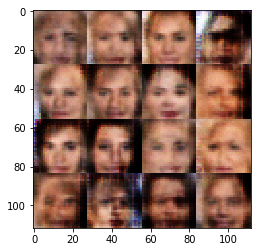

Steps 610/1... Discriminator Loss: 1.3080... Generator Loss: 0.5134
Steps 620/1... Discriminator Loss: 0.7881... Generator Loss: 1.1138
Steps 630/1... Discriminator Loss: 0.9666... Generator Loss: 0.8466
Steps 640/1... Discriminator Loss: 1.0495... Generator Loss: 0.7260
Steps 650/1... Discriminator Loss: 0.9541... Generator Loss: 0.8210
Steps 660/1... Discriminator Loss: 1.0670... Generator Loss: 0.6937
Steps 670/1... Discriminator Loss: 0.7124... Generator Loss: 1.3979
Steps 680/1... Discriminator Loss: 0.9109... Generator Loss: 0.9552
Steps 690/1... Discriminator Loss: 0.7319... Generator Loss: 1.6054
Steps 700/1... Discriminator Loss: 0.8625... Generator Loss: 0.9877


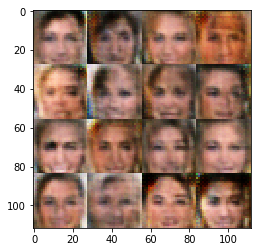

Steps 710/1... Discriminator Loss: 0.9502... Generator Loss: 0.9672
Steps 720/1... Discriminator Loss: 1.1260... Generator Loss: 0.8336
Steps 730/1... Discriminator Loss: 1.0293... Generator Loss: 0.7977
Steps 740/1... Discriminator Loss: 0.9721... Generator Loss: 0.8496
Steps 750/1... Discriminator Loss: 0.9057... Generator Loss: 1.1717
Steps 760/1... Discriminator Loss: 0.9589... Generator Loss: 0.8262
Steps 770/1... Discriminator Loss: 1.6758... Generator Loss: 0.3319
Steps 780/1... Discriminator Loss: 1.1902... Generator Loss: 0.7846
Steps 790/1... Discriminator Loss: 1.1042... Generator Loss: 0.7473
Steps 800/1... Discriminator Loss: 1.0467... Generator Loss: 0.8000


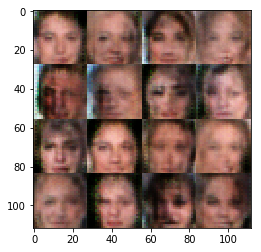

Steps 810/1... Discriminator Loss: 0.6965... Generator Loss: 1.7278
Steps 820/1... Discriminator Loss: 1.2103... Generator Loss: 0.5945
Steps 830/1... Discriminator Loss: 0.9050... Generator Loss: 1.0502
Steps 840/1... Discriminator Loss: 0.8915... Generator Loss: 1.3571
Steps 850/1... Discriminator Loss: 1.0854... Generator Loss: 0.7161
Steps 860/1... Discriminator Loss: 0.9014... Generator Loss: 1.1707
Steps 870/1... Discriminator Loss: 0.8056... Generator Loss: 1.2675
Steps 880/1... Discriminator Loss: 0.9914... Generator Loss: 1.1255
Steps 890/1... Discriminator Loss: 0.9512... Generator Loss: 0.9119
Steps 900/1... Discriminator Loss: 1.1419... Generator Loss: 0.9603


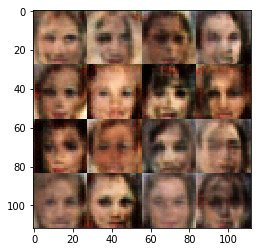

Steps 910/1... Discriminator Loss: 1.1540... Generator Loss: 0.7925
Steps 920/1... Discriminator Loss: 1.1290... Generator Loss: 0.8999
Steps 930/1... Discriminator Loss: 1.1590... Generator Loss: 0.8861
Steps 940/1... Discriminator Loss: 1.0899... Generator Loss: 0.7793
Steps 950/1... Discriminator Loss: 1.0188... Generator Loss: 0.9388
Steps 960/1... Discriminator Loss: 0.8835... Generator Loss: 0.9613
Steps 970/1... Discriminator Loss: 0.7103... Generator Loss: 1.8355
Steps 980/1... Discriminator Loss: 0.7917... Generator Loss: 1.2150
Steps 990/1... Discriminator Loss: 1.3495... Generator Loss: 0.5153
Steps 1000/1... Discriminator Loss: 1.2740... Generator Loss: 0.6803


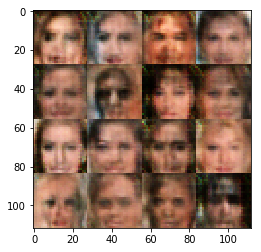

Steps 1010/1... Discriminator Loss: 0.9943... Generator Loss: 0.9025
Steps 1020/1... Discriminator Loss: 2.3281... Generator Loss: 3.2306
Steps 1030/1... Discriminator Loss: 1.0419... Generator Loss: 0.8682
Steps 1040/1... Discriminator Loss: 1.1241... Generator Loss: 0.6709
Steps 1050/1... Discriminator Loss: 1.0650... Generator Loss: 1.0189
Steps 1060/1... Discriminator Loss: 0.8949... Generator Loss: 1.0463
Steps 1070/1... Discriminator Loss: 0.9442... Generator Loss: 0.9350
Steps 1080/1... Discriminator Loss: 1.2159... Generator Loss: 0.5938
Steps 1090/1... Discriminator Loss: 1.2079... Generator Loss: 0.6828
Steps 1100/1... Discriminator Loss: 1.0225... Generator Loss: 0.8325


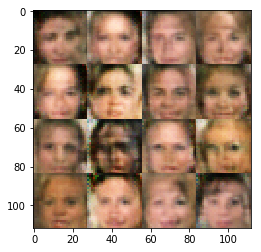

Steps 1110/1... Discriminator Loss: 1.0543... Generator Loss: 0.9859
Steps 1120/1... Discriminator Loss: 0.9763... Generator Loss: 0.9126
Steps 1130/1... Discriminator Loss: 0.9244... Generator Loss: 0.8848
Steps 1140/1... Discriminator Loss: 1.0693... Generator Loss: 1.2307
Steps 1150/1... Discriminator Loss: 1.0830... Generator Loss: 0.9510
Steps 1160/1... Discriminator Loss: 1.0635... Generator Loss: 0.8682
Steps 1170/1... Discriminator Loss: 1.0549... Generator Loss: 1.6341
Steps 1180/1... Discriminator Loss: 1.1295... Generator Loss: 0.7078
Steps 1190/1... Discriminator Loss: 0.9955... Generator Loss: 0.9900
Steps 1200/1... Discriminator Loss: 1.4653... Generator Loss: 1.5664


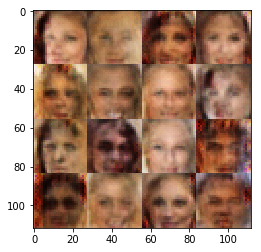

Steps 1210/1... Discriminator Loss: 1.1862... Generator Loss: 0.8798
Steps 1220/1... Discriminator Loss: 1.2049... Generator Loss: 0.8723
Steps 1230/1... Discriminator Loss: 1.2667... Generator Loss: 0.7763
Steps 1240/1... Discriminator Loss: 1.0921... Generator Loss: 0.9667
Steps 1250/1... Discriminator Loss: 1.0972... Generator Loss: 0.8674
Steps 1260/1... Discriminator Loss: 1.0858... Generator Loss: 0.7658
Steps 1270/1... Discriminator Loss: 0.9231... Generator Loss: 0.9075
Steps 1280/1... Discriminator Loss: 0.9571... Generator Loss: 1.2695
Steps 1290/1... Discriminator Loss: 1.4815... Generator Loss: 0.4104
Steps 1300/1... Discriminator Loss: 1.1965... Generator Loss: 0.6773


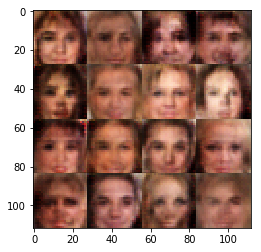

Steps 1310/1... Discriminator Loss: 1.3800... Generator Loss: 0.4692
Steps 1320/1... Discriminator Loss: 1.0908... Generator Loss: 0.9578
Steps 1330/1... Discriminator Loss: 1.2078... Generator Loss: 0.8401
Steps 1340/1... Discriminator Loss: 1.1523... Generator Loss: 1.0649
Steps 1350/1... Discriminator Loss: 1.1095... Generator Loss: 0.6928
Steps 1360/1... Discriminator Loss: 1.2228... Generator Loss: 0.6113
Steps 1370/1... Discriminator Loss: 1.3859... Generator Loss: 0.4750
Steps 1380/1... Discriminator Loss: 1.2153... Generator Loss: 0.7322
Steps 1390/1... Discriminator Loss: 1.5710... Generator Loss: 0.3795
Steps 1400/1... Discriminator Loss: 0.8940... Generator Loss: 1.3380


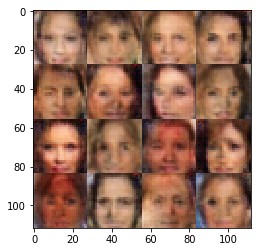

Steps 1410/1... Discriminator Loss: 1.1167... Generator Loss: 0.6775
Steps 1420/1... Discriminator Loss: 1.2464... Generator Loss: 0.5682
Steps 1430/1... Discriminator Loss: 0.9401... Generator Loss: 1.5758
Steps 1440/1... Discriminator Loss: 1.0642... Generator Loss: 0.7425
Steps 1450/1... Discriminator Loss: 1.0268... Generator Loss: 0.8741
Steps 1460/1... Discriminator Loss: 1.0503... Generator Loss: 0.7899
Steps 1470/1... Discriminator Loss: 1.2254... Generator Loss: 0.6278
Steps 1480/1... Discriminator Loss: 1.1000... Generator Loss: 0.9509
Steps 1490/1... Discriminator Loss: 1.1861... Generator Loss: 0.6317
Steps 1500/1... Discriminator Loss: 0.7650... Generator Loss: 1.5380


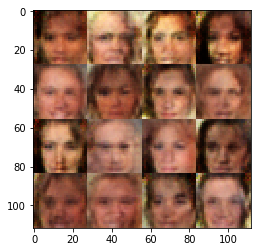

Steps 1510/1... Discriminator Loss: 1.1766... Generator Loss: 0.6468
Steps 1520/1... Discriminator Loss: 1.3072... Generator Loss: 0.5218
Steps 1530/1... Discriminator Loss: 1.0263... Generator Loss: 1.1717
Steps 1540/1... Discriminator Loss: 1.2430... Generator Loss: 1.1465
Steps 1550/1... Discriminator Loss: 1.0574... Generator Loss: 0.8036
Steps 1560/1... Discriminator Loss: 1.0725... Generator Loss: 0.9097
Steps 1570/1... Discriminator Loss: 1.1034... Generator Loss: 0.8163
Steps 1580/1... Discriminator Loss: 1.1501... Generator Loss: 0.7697
After epoch


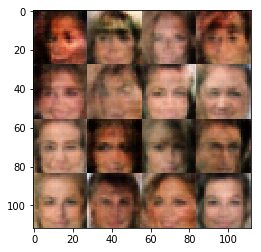

Done


In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.00075
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.